# Features Importance Using Deep & Cross Network (DCN-V2)


![logo_small](https://user-images.githubusercontent.com/67468718/127299425-533f0a3c-c965-42a5-886a-5272170d9e0e.JPG)



## 1. Introduction: Deep & Cross Network (DCN-V2)

**Deep and cross network, short for DCN**, came out of Google Research, and is designed to learn explicit and bounded-degree cross features effectively:
 * large and sparse feature space is extremely hard to train.
 * Oftentimes, we needed to do a lot of manual feature engineering, including designing cross features, which is very challenging and less effective.
 * Whilst possible to use additional neural networks under such circumstances, it's not the most efficient approach.
 
***Deep and cross network (DCN) is specifically designed to tackle all above challenges.***


### 1.1 Feature Cross

Let's say we're building a recommender system to sell a blender to customers. Then our customers' past purchase history, such as purchased bananas and purchased cooking books, or geographic features are single features. If one has purchased both bananas and cooking books, then this customer will be more likely to click on the recommended blender. The combination of purchased bananas and the purchased cooking books is referred to as feature cross, which provides additional interaction information beyond the individual features. You can keep adding more cross features to even higher degrees:

![feature_cross](https://user-images.githubusercontent.com/67468718/135774082-c46d2f22-ea20-451c-af1a-ee4453f69176.JPG)

### 1.2 Cross Network

In real world recommendation systems, we often have large and sparse feature space. So identifying effective feature processes in this setting would often require manual feature engineering or exhaustive search, which is highly inefficient. To tackle this issue, ***Google Research team has proposed Deep and Cross Network, DCN.***

It starts with an input layer, typically an embedding layer, followed by a cross network containing multiple cross layers that models explicitly feature interactions, and then combines with a deep network that models implicit feature interactions. The deep network is just a traditional multilayer construction. But the core of DCN is really the cross network. It explicitly applies feature crossing at each layer. And the highest polynomial degree increases with layer depth. The figure here shows the deep and cross layer in the mathematical form.

![dcn](https://user-images.githubusercontent.com/67468718/135774206-d017c326-2568-49ce-ab13-98b696e6de84.JPG)

### 1.3 Deep & Cross Network Architecture

There are a couple of ways to combine the cross network and the deep networ:
 * Stack the deep network on top of the cross network.
 * Place deep & cross networs in parallel.
 
![DCN_structure](https://user-images.githubusercontent.com/67468718/135774992-b26eabcf-bd9e-40c2-b702-abb1cb193ff7.JPG)

## 2. Dataset: 

**Movie Lens** contains a set of movie ratings from the MovieLens website, a movie recommendation service. This dataset was collected and maintained by [GroupLens](https://grouplens.org/) , a research group at the University of Minnesota. There are 5 versions included: "25m", "latest-small", "100k", "1m", "20m". In all datasets, the movies data and ratings data are joined on "movieId". The 25m dataset, latest-small dataset, and 20m dataset contain only movie data and rating data. The 1m dataset and 100k dataset contain demographic data in addition to movie and rating data.

**movie_lens/1m** can be treated in two ways:

  * It can be interpreted as expressesing which movies the users watched (and rated), and which they did not. This is a form of *implicit feedback*, where users' watches tell us which things they prefer to see and which they'd rather not see (This means that every movie a user watched is a positive example, and every movie they have not seen is an implicit negative example).
  * It can also be seen as expressesing how much the users liked the movies they did watch. This is a form of *explicit feedback*: given that a user watched a movie, we can tell roughly how much they liked by looking at the rating they have given.



**(a) [movie_lens/1m-ratings](https://www.tensorflow.org/datasets/catalog/movie_lens#movie_lens1m-ratings):**
 * Config description: This dataset contains 1,000,085 anonymous ratings of approximately 3,619 movies made by 6,040 MovieLens users who joined MovieLens. Ratings are in whole-star increments. This dataset contains demographic data of users in addition to data on movies and ratings.
 * This dataset is the largest dataset that includes demographic data from movie_lens.
 * "user_gender": gender of the user who made the rating; a true value corresponds to male
 * "bucketized_user_age": bucketized age values of the user who made the rating, the values and the corresponding ranges are:
   * 1: "Under 18"
   * 18: "18-24"
   * 25: "25-34"
   * 35: "35-44"
   * 45: "45-49"
   * 50: "50-55"
   * 56: "56+"
 * "user_occupation_label": the occupation of the user who made the rating represented by an integer-encoded label; labels are preprocessed to be consistent across different versions
 * "user_occupation_text": the occupation of the user who made the rating in the original string; different versions can have different set of raw text labels
 * "user_zip_code": the zip code of the user who made the rating.
 * "release_date": This is the movie release date, in unix epoch (UTC - units of seconds) (int64).
 * "director": This is the director of the movie.
 * "start": This is the main star of the movie.



## 3. Sourcing and Loading

### 3.1 Import relevant libraries

In [2]:
# Import the necessary Libararies: 

import os
import pprint
import tempfile
import matplotlib.pyplot as plt
from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Dict, Text
import pandas as pd
import numpy as np

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

plt.style.use('ggplot')

### 3.2 Preparing the dataset

Let's first have a look at the data.

We use the MovieLens dataset from Tensorflow Datasets. Loading **[movie_lens/1m-ratings](https://www.tensorflow.org/datasets/catalog/movie_lens#movie_lens1m-ratings)** yields a ***tf.data.Dataset*** object containing the ratings data and loading **[movie_lens/1m-movies](https://www.tensorflow.org/datasets/catalog/movie_lens#movie_lens1m-movies)** yields a ***tf.data.Dataset*** object containing only the movies data.

Note that since the MovieLens dataset does not have predefined splits, all data are under train split.

In [3]:
# Now, let's look at the final dataframe where we merged tensorflow dataset with movies_metadata.csv and credits.csv**
# let's make sure to use encoding argument to avoid in encoding errors !!!
ratings = pd.read_csv('ratings.csv', encoding='ISO-8859-1')

In [4]:
# now let's look at the new features we added: 'movie_imdb_id', 'cast', 'director', 'cast_size', 'crew_size', 'imdb_id' and 'release_date':
#Also, please note that all wrong spelled movies are corrected!!!!
ratings.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code,director,release_date,star
0,50,[7],1251,Eight and half,974089380,False,2497,14,sales/marketing,3,37922,Federico Fellini,-217123200,Marcello Mastroianni
1,18,[7],1251,Eight and half,986722200,True,671,17,college/grad student,5,61761,Federico Fellini,-217123200,Marcello Mastroianni
2,45,[7],1251,Eight and half,960071880,False,5590,12,programmer,2,94117,Federico Fellini,-217123200,Marcello Mastroianni
3,25,[7],1251,Eight and half,1011993120,True,1851,20,unemployed,5,59602,Federico Fellini,-217123200,Marcello Mastroianni
4,35,[7],1251,Eight and half,963100320,False,5526,1,artist,5,27514,Federico Fellini,-217123200,Marcello Mastroianni


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000085 entries, 0 to 1000084
Data columns (total 14 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   bucketized_user_age    1000085 non-null  int64 
 1   movie_genres           1000085 non-null  object
 2   movie_id               1000085 non-null  int64 
 3   movie_title            1000085 non-null  object
 4   timestamp              1000085 non-null  int64 
 5   user_gender            1000085 non-null  bool  
 6   user_id                1000085 non-null  int64 
 7   user_occupation_label  1000085 non-null  int64 
 8   user_occupation_text   1000085 non-null  object
 9   user_rating            1000085 non-null  int64 
 10  user_zip_code          1000085 non-null  int64 
 11  director               1000085 non-null  object
 12  release_date           1000085 non-null  int64 
 13  star                   1000085 non-null  object
dtypes: bool(1), int64(8), object(5)
me

In [6]:
# movie_id from int to str:
ratings['movie_id'] = ratings['movie_id'].astype('str')

In [7]:
# user_id from int to str:
ratings['user_id'] = ratings['user_id'].astype('str')

In [8]:
# user_zip_code from int to str:
ratings['user_zip_code'] = ratings['user_zip_code'].astype('str')

In [9]:
#let's have a general view of main_df:
ratings_missing = pd.concat([ratings.nunique(), ratings.dtypes, ratings.isnull().sum(), 100*ratings.isnull().mean()], axis=1)
ratings_missing.columns = [['count', 'data_type', 'missing_count', 'missing%']]
ratings_missing

,count,data_type,missing_count,missing%
bucketized_user_age,7,int64,0,0.0
movie_genres,302,object,0,0.0
movie_id,3656,object,0,0.0
movie_title,3619,object,0,0.0
timestamp,174246,int64,0,0.0
user_gender,2,bool,0,0.0
user_id,6040,object,0,0.0
user_occupation_label,21,int64,0,0.0
user_occupation_text,21,object,0,0.0
user_rating,5,int64,0,0.0


In [10]:
#let's wrap the **pandas dataframe** into **tf.data.Dataset** object using **tf.data.Dataset.from_tensor_slices** using: tf.data.Dataset.from_tensor_slices
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings))

In [11]:
#The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:
#View the data from ratings dataset:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'bucketized_user_age': 50,
 'director': b'Federico Fellini',
 'movie_genres': b'[7]',
 'movie_id': b'1251',
 'movie_title': b'Eight and half ',
 'release_date': -217123200,
 'star': b'Marcello Mastroianni',
 'timestamp': 974089380,
 'user_gender': False,
 'user_id': b'2497',
 'user_occupation_label': 14,
 'user_occupation_text': b'sales/marketing',
 'user_rating': 3,
 'user_zip_code': b'37922'}


In [12]:
type(ratings)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

Next, we're only going to extract the movie title and the user id. So, we're actually not going to extract the rating itself and the reason why is that we're treating these as **implicit recommendations** in this case because that's easier to do a large scale like we mentioned earlier we want to try to keep things simple in **the retrieval stage** because it's operating over potentially a massive amount of data so to that end we're just going to assume that any movie that a user rated is one that they were really interested in if they took the time to watch it then it expresses some level of interest:

***Any rating is an implicit positive rating for a movie and the absence of a rating is an implicit negative rating for that movie***

In [23]:
#Let's select the necessary attributes:

ratings = ratings.map(lambda x: {
                                 "movie_id": x["movie_id"],
                                 "user_id": x["user_id"],
                                 "user_rating": x["user_rating"],
                                 "user_gender": int(x["user_gender"]),
                                 "user_zip_code": x["user_zip_code"],
                                 "user_occupation_text": x["user_occupation_text"],
                                 "director": x["director"],
                                 "star": x["star"],
                                 "movie_genres": x["movie_genres"],    
                                 "bucketized_user_age": int(x["bucketized_user_age"]),                                
                                })



In [24]:
len(ratings)

1000085

In [25]:
# let's use a random split, putting 75% of the ratings in the train set, and 25% in the test set:
# Assign a seed=42 for consistency of results and reproducibility:
seed = 42
l = len(ratings)

tf.random.set_seed(seed)
shuffled = ratings.shuffle(l, seed=seed, reshuffle_each_iteration=False)

#Save 75% of the data for training and 25% for testing:
train_ = int(0.75 * l)
test_ = int(0.25 * l)

train = shuffled.take(train_)
test = shuffled.skip(train_).take(test_)

In [26]:
#Then, let's create vocabulary for each feature:

feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age", "director", "star"]

vocabularies = {}

for feature_name in feature_names:
    vocab = ratings.batch(l).map(lambda x: x[feature_name])
    vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

## 4. Model construction

The model architecture we will be building starts with an embedding layer, which is fed into a cross network followed by a deep network. The embedding dimension is set to 32 for all the features. You could also use different embedding sizes for different features.

In [27]:
class DCN(tfrs.Model):
    def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
        super().__init__()

        self.embedding_dimension = 32

        str_features = ["movie_id", "user_id", "user_zip_code", 
                        "user_occupation_text", "director", "star"]
        int_features = ["user_gender", "bucketized_user_age"]

        self._all_features = str_features + int_features
        self._embeddings = {}

        # Compute embeddings for string features. experimental.preprocessing
        # WARNING:tensorflow:mask_value is deprecated, use mask_token instead.
        for feature_name in str_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                                                                [tf.keras.layers.experimental.preprocessing.StringLookup(
                                                                 vocabulary=vocabulary, mask_token=None),
                                                                 tf.keras.layers.Embedding(len(vocabulary) + 1,
                                                                 self.embedding_dimension)
                                           ])
      
        # Compute embeddings for int features.
        for feature_name in int_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                                                                 [tf.keras.layers.experimental.preprocessing.IntegerLookup(
                                                                 vocabulary=vocabulary, mask_token=None), 
                                                                 tf.keras.layers.Embedding(len(vocabulary) + 1,
                                                                 self.embedding_dimension)
                                           ])

        if use_cross_layer:
            self._cross_layer = tfrs.layers.dcn.Cross(
                                                      projection_dim=projection_dim,
                                                      kernel_initializer="glorot_uniform")
        else:
            self._cross_layer = None

        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
            for layer_size in deep_layer_sizes]

        self._logit_layer = tf.keras.layers.Dense(1)

        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
            )

    def call(self, features):
        # Concatenate embeddings
        embeddings = []
        for feature_name in self._all_features:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))

        x = tf.concat(embeddings, axis=1)

        # Build Cross Network
        if self._cross_layer is not None:
            x = self._cross_layer(x)
    
    # Build Deep Network
        for deep_layer in self._deep_layers:
            x = deep_layer(x)

        return self._logit_layer(x)

    def compute_loss(self, features, training=False):
        labels = features.pop("user_rating")
        scores = self(features)
        return self.task(labels=labels,predictions=scores,
        )        

### 4.1 Model Training

In [28]:
# Then shuffle, batch, and cache the training and evaluation data:
# Segment the batches so that the model runs 13 training batches (2^13) and 11 test batches (2^11) per epoch, 
# while having a batch size which is a multiple of 2^n.
cached_train = train.shuffle(l).batch(8192).cache()
cached_test = test.batch(2048).cache()

Now let's define a function that runs a model multiple times and returns the model's RMSE mean and standard deviation out of multiple runs

In [29]:
def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
    models = []
    rmses = []

    for i in range(num_runs):
        model = DCN(use_cross_layer=use_cross_layer,
                    deep_layer_sizes=deep_layer_sizes,
                    projection_dim=projection_dim)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
        models.append(model)

        model.fit(cached_train, epochs=epochs, verbose=False)
        metrics = model.evaluate(cached_test, return_dict=True)
        rmses.append(metrics["RMSE"])

    mean, stdv = np.average(rmses), np.std(rmses)

    return {"model": models, "mean": mean, "stdv": stdv}

We set some hyper-parameters for the models. Note that these hyper-parameters are set globally for all the models for demonstration purpose. If you want to obtain the best performance for each model, or conduct a fair comparison among models, then we'd suggest you to fine-tune the hyper-parameters. Remember that the model architecture and optimization schemes are intertwined.

In [30]:
epochs = 32
learning_rate = 0.01

#### 4.1.1 DCN (stacked)

We first train a DCN model with a stacked structure, that is, the inputs are fed to a cross network followed by a deep network.

![DCN_stacked](https://user-images.githubusercontent.com/67468718/135777802-cacec165-ed8c-4951-85ee-f3fe1f421b4d.JPG)

In [31]:
dcn_result = run_models(use_cross_layer=True, deep_layer_sizes=[192, 192])

123/123 [==============================] - 2s 14ms/step - RMSE: 1.0434 - loss: 1.0897 - regularization_loss: 0.0000e+00 - total_loss: 1.0897


Visualizing the Weight Matrix Learned by DCN


C:\Users\aktha\anaconda3\envs\tfrs\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\aktha\anaconda3\envs\tfrs\lib\site-packages\ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 864x864 with 0 Axes>

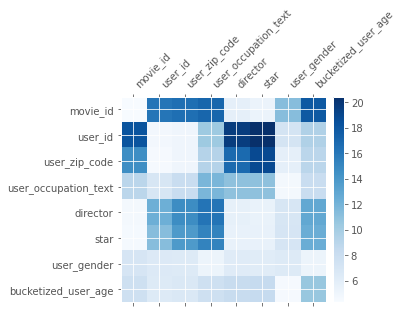

In [32]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])
dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
    for j in range(len(features)):
        block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
        block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(12,12))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)
#plt.title('Visualizing the Weight Matrix Learned by DCN')
print('Visualizing the Weight Matrix Learned by DCN')

One of the nice things about DCN is that you can visualize the weights from the cross network and see if it has successfully learned the important feature process.
As shown above, the stronger the interaction between two features is. In this case, the feature cross of user ID and movie ID is of great importance.

#### 4.1.2 Low-rank DCN

To reduce the training and serving cost, we leverage low-rank techniques to approximate the DCN weight matrices. The rank is passed in through argument projection_dim; a smaller projection_dim results in a lower cost. Note that projection_dim needs to be smaller than (input size)/2 to reduce the cost. In practice, we've observed using low-rank DCN with rank (input size)/4 consistently preserved the accuracy of a full-rank DCN.

![low-rank-dcn](https://user-images.githubusercontent.com/67468718/137226644-e5bebcf9-2648-407c-94a5-108435076570.JPG)

In [33]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

123/123 [==============================] - 2s 11ms/step - RMSE: 0.9959 - loss: 0.9889 - regularization_loss: 0.0000e+00 - total_loss: 0.9889


#### 4.1.3 DNN (Cross Layer = False)

We train a same-sized DNN model as a reference.

In [34]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

123/123 [==============================] - 3s 18ms/step - RMSE: 0.9833 - loss: 0.9681 - regularization_loss: 0.0000e+00 - total_loss: 0.9681


In [35]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(dnn_result["mean"], dnn_result["stdv"]))

DCN            RMSE mean: 1.0354, stdv: 0.0225
DCN (low-rank) RMSE mean: 1.0098, stdv: 0.0207
DNN            RMSE mean: 0.9535, stdv: 0.0244


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))